In [1]:
!pip install scikit-learn
import numpy as np 
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
!pip install opencv-python
import cv2
import matplotlib.pyplot as plt
!pip install tensorflow
import tensorflow as tf


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
def load_dir_into_df(directory='C:/Users/Aojie Ju/Downloads/PARM/RiskLab/archive/data/training_data'):
    im_paths_list = []
    im_labels_list = []
    class_dict = {}
    all_labels = []
    # im_paths_list: Will hold the paths to each image.
    # im_labels_list: Will hold the corresponding labels for each image.
    # class_dict: A dictionary to map folder names (classes) to numerical labels.
    # all_labels: A list to store the names of all labels.
    for i,dir in enumerate(sorted(os.listdir(directory))): # lists all subdirectories (each folder represents a class, e.g., “0”, “1”, etc.)
        # enumerate: assigns an index number (i) to each folder (dir)
        class_dict[dir] = i
        all_labels.append(dir)
        for impath in sorted(os.listdir(os.path.join(directory,dir))):
            im_paths_list.append(os.path.join(directory,dir,impath))
            im_labels_list.append(i)
            # For each subdirectory (dir), os.listdir(os.path.join(directory, dir)) lists all files (images) in that folder.
            # Append Image Paths: im_paths_list.append(os.path.join(directory, dir, impath)) appends the full path of each image to the list.
            # Append Labels: im_labels_list.append(i) assigns the numerical label (i) corresponding to the folder to each image. The labels in im_labels_list are associated with the images in im_paths_list.
    df = pd.DataFrame({'img': im_paths_list,'label': im_labels_list})
    return df, class_dict, all_labels
data_df, class_dict, all_labels = load_dir_into_df()
data_df.head()

,img,label
0,C:/Users/Aojie Ju/Downloads/PARM/RiskLab/archi...,0
1,C:/Users/Aojie Ju/Downloads/PARM/RiskLab/archi...,0
2,C:/Users/Aojie Ju/Downloads/PARM/RiskLab/archi...,0
3,C:/Users/Aojie Ju/Downloads/PARM/RiskLab/archi...,0
4,C:/Users/Aojie Ju/Downloads/PARM/RiskLab/archi...,0


In [3]:
# splitting data to train - test
inputs = data_df['img']
labels = data_df['label']

x_train, x_test, y_train, y_test = train_test_split(inputs,labels,test_size=0.3,shuffle=True)

In [4]:
# method to load image given the path and resize it to (30,30,3)
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3, dtype=tf.uint8)
    img = tf.image.resize(img, [30,30])
    return img

# method to extract the label and read the image
# used for map in tf.data.dataset
def extract_label_read_img(img_path):
    img = load_img(img_path)
    label_char = tf.strings.split(img_path,sep = tf.constant("/"))[6]
    return img, label_char

# method to normalize the pixel values and make them in interval [0,1]
def preprocess_img(img, label):
    img = img/255.0
    return img,label

# method to transform label from string form to one hot encoded vector
def one_hot_encode(img, label):
    # Convert the label from string to integer index
    label_int = table.lookup(label)
    # One-hot encode the integer index
    label_one_hot = tf.one_hot(label_int, depth=36)
    return img, label_one_hot

In [5]:
unique_labels = sorted(set(all_labels))

# Create a lookup table to convert string labels to integers
table = tf.lookup.StaticVocabularyTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(unique_labels, dtype=tf.string),
        values=tf.constant(range(len(unique_labels)), dtype=tf.int64)
    ),
    num_oov_buckets=1  # Out-of-vocabulary bucket
)

num_classes = len(unique_labels)

In [6]:
# creating the training and test datasets
batch_size = 32
train_data_set = tf.data.Dataset.from_tensor_slices(list(x_train))
train_data_set = train_data_set.map(extract_label_read_img)
train_data_set = train_data_set.map(preprocess_img)
train_data_set = train_data_set.map(one_hot_encode)
train_data_set = train_data_set.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_data_set = tf.data.Dataset.from_tensor_slices(list(x_test))
test_data_set = test_data_set.map(extract_label_read_img)
test_data_set = test_data_set.map(preprocess_img)
test_data_set = test_data_set.map(one_hot_encode)
test_data_set = test_data_set.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

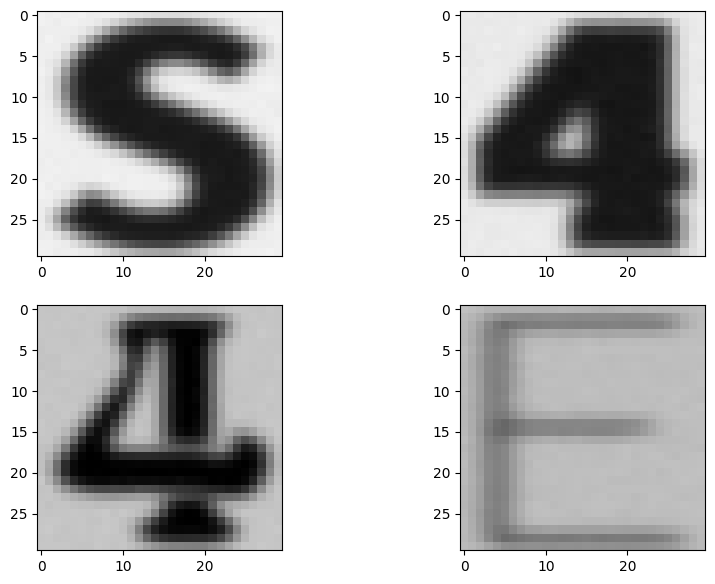

In [7]:
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2
n=1
image = []
label = 0
for i,j in train_data_set.shuffle(3).take(4):
    image = i[1]
    label = j.numpy()[1]
    fig.add_subplot(rows, columns, n)
    n += 1
    plt.imshow(i[1])
#     plt.title(j.numpy())

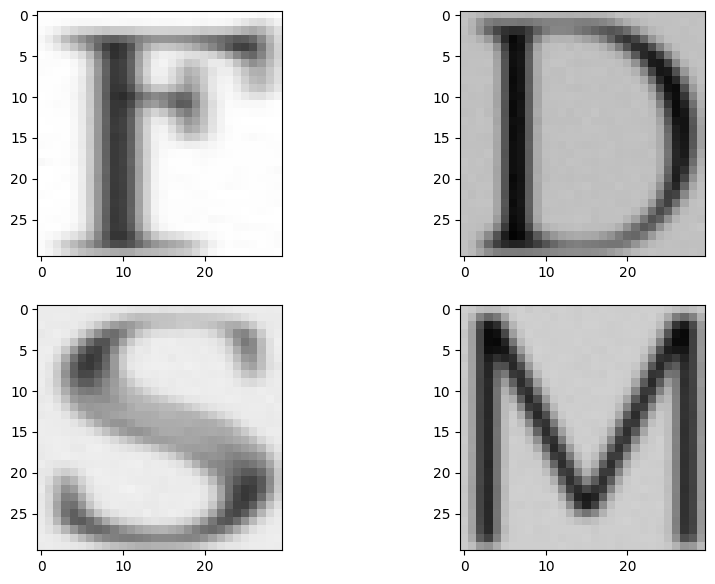

In [8]:
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2
n=1
for i,j in test_data_set.shuffle(3).take(4):
    image = i[1]
    label = j[1]
    fig.add_subplot(rows, columns, n)
    n += 1
    plt.imshow(i[1])


In [9]:
# testing using model
inputs = tf.keras.Input(shape=(30,30,3))
# define the size of input images, 30*30 pixels with 3 channels.
conv_layer_1 = tf.keras.layers.Conv2D(16, 3, padding='valid', activation="relu")
# apply 16 filters to the input image, each of size 3*3, extracting features

# pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
# adding a pooling layer here to reduce the size of feature maps and reduce overfitting?

flatten_layer = tf.keras.layers.Flatten()
# converts the 2d feature maps produced by conv_layer into a 1d vector
dense_layer = tf.keras.layers.Dense(units=60, activation='relu')
# fully connected layer with 60 neurons
classification_layer = tf.keras.layers.Dense(units=36,activation='softmax')
# dense layer has 36 units, implying 36 possible classes that the model is trying to classfy:
# softmax activation, making it suitable for multi-class classification, helping differentiate between letters or digits
x = conv_layer_1(inputs)
# x = pooling_layer(x)
x = flatten_layer(x)
x = dense_layer(x)
outputs = classification_layer(x)

model = tf.keras.Model(outputs=outputs,inputs=inputs)

# Summary: CNN.

In [10]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=[tf.keras.metrics.F1Score(average=None, threshold=None, name="f1_score", dtype=None),tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)])
model.fit(train_data_set,epochs=10)

Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - categorical_accuracy: 0.0361 - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - categorical_accuracy: 0.0214 - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - categorical_accuracy: 0.0239 - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - categorical_accuracy: 0.0292 - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - categorical_accuracy: 0.0241 - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - categorical_accuracy: 0.0303 - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - categorical_accuracy: 0.0258 - f1_score: 0.0000e+00 - loss: 0.0000e+00
Epoch 8/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - categorical_accuracy: 0.0317 - f1_score: 0.0000e+00 - l

In [11]:
predictions = model.predict(test_data_set)

194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


In [12]:
pred = np.argmax(predictions, axis=1)
print(pred)
y_test = [label.numpy() for image,label in test_data_set.unbatch()]
y_test = np.argmax(y_test,axis = 1)
print(y_test)

[30 30 30 ... 30 30 30]
[0 0 0 ... 0 0 0]


In [13]:
report = classification_report(y_test,pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    6189.0
          30       0.00      0.00      0.00       0.0

    accuracy                           0.00    6189.0
   macro avg       0.00      0.00      0.00    6189.0
weighted avg       0.00      0.00      0.00    6189.0



c:\Users\Aojie Ju\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aojie Ju\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aojie Ju\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

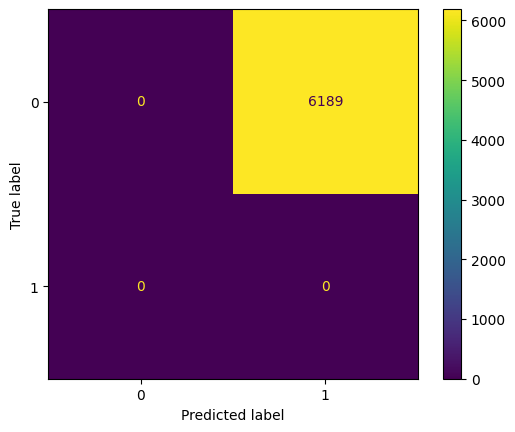

In [14]:
cm = confusion_matrix(y_test,pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()